In [9]:
import sys
import xarray as xr
from pathlib import Path
import cftime

In [2]:
def fix_time(ds):
    """If days are missing, fix the dataset by adding NaN values for those days.
    Ensures time starts on Jan 1 and ends on Dec 31.
    Dates are in CF-compliant format: units 'days since 1950-01-01', calendar 'noleap'.
    """
    var = list(ds.data_vars)[0]
    src = ds[var].encoding.get("source", "unknown")

    # Get the time variable as cftime objects
    time = ds["time"].values
    if not isinstance(time[0], cftime.DatetimeNoLeap):
        time = xr.cftime_range(
            start=str(ds["time"].values[0]),
            end=str(ds["time"].values[-1]),
            freq="D",
            calendar="noleap",
        )
    else:
        time = ds["time"].values

    # Ensure time starts on Jan 1 and ends on Dec 31, use hour 12 to match input file specs
    start_year = time[0].year
    end_year = time[-1].year
    start = cftime.DatetimeNoLeap(start_year, 1, 1, 12)
    end = cftime.DatetimeNoLeap(end_year, 12, 31, 12)
    all_days = xr.cftime_range(start=start, end=end, freq="D", calendar="noleap")
    missing_days = sorted(set(all_days) - set(time))

    if len(missing_days) == 365 or len(missing_days) == 0:
        # this is a case where the hour is set to 0 instead of 12 (CESM2 model)
        # here we just want to skip the filling of NaN values and assume the time is correct
        # Set CF-compliant encoding and return
        ds["time"].encoding.update(
            {"units": "days since 1950-01-01", "calendar": "noleap"}
        )
        return ds

    if missing_days:
        print(
            f"Missing days ({len(missing_days)}) in {src}: {missing_days[:5]}{'...' if len(missing_days) > 5 else ''} .... attempting to add all NaN array for these days."
        )
        # drop any dtype encoding in the time dimension - some int64 encoding remnants cause issues!
        ds["time"].encoding.pop("dtype", None)
        # Reindex to include all days, fill_value for missing days is NaN
        ds = ds.reindex(time=all_days)

        # Set CF-compliant encoding
        ds["time"].encoding.update(
            {"units": "days since 1950-01-01", "calendar": "noleap"}
        )
        return ds

In [ ]:
def fix_CESM2_time(ds):
    """Fix the time variable for CESM2 datasets so that the hour is set to 12 instead of 0."""
    import cftime
    import numpy as np
    import xarray as xr

    if "time" in ds:
        time = ds["time"].values
        if isinstance(time[0], cftime.DatetimeNoLeap):
            # Convert to 12:00 noon
            new_time = np.array(
                [cftime.DatetimeNoLeap(t.year, t.month, t.day, 12) for t in time]
            )
            # Create a new DataArray for time
            new_time_da = xr.DataArray(
                new_time,
                dims=ds["time"].dims,
                coords=ds["time"].coords,
                # attrs=ds["time"].attrs,
            )
            # Set encoding for CF compliance
            new_time_da.encoding.update(
                {"units": "days since 1950-01-01", "calendar": "noleap"}
            )
            ds = ds.assign_coords(time=new_time_da)
    return ds

In [11]:
dir = "/beegfs/CMIP6/jdpaul3/CMIP6_common_regrid/regrid/"
# output where the fixed files will be saved
output_dir = Path("/beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix")

In [12]:
# list all daily *.nc files in the directory and any subdirectories
all_daily_files = list(Path(dir).rglob("*day_*.nc"))

In [5]:
# for each file, open it and add missing days, and save it to the output directory with the same directory structure
# limit this to variables pr, tasmin, and tasmax
files = [f for f in all_daily_files if f.name.startswith(("pr_", "tasmin_", "tasmax_"))]

for file in files:
    # does the output file already exist? if so, don't do anything
    output_file = output_dir / file.relative_to(dir)
    # if output_file.exists():
    #     continue

    try:
        ds = xr.open_dataset(file, decode_cf=True)
        ds = fix_time(ds)

        output_file.parent.mkdir(
            parents=True, exist_ok=True
        )  # Create parent directories if they don't exist
        ds.to_netcdf(output_file, mode="w", format="NETCDF4")
        ds.close()
        # print(f"Saved {file} successfully.")
    except Exception as e:
        print(f"Error processing {file}: {e}", file=sys.stderr)

Missing days (30) in /beegfs/CMIP6/jdpaul3/CMIP6_common_regrid/regrid/E3SM-2-0/ssp370/day/tasmin/tasmin_day_E3SM-2-0_ssp370_regrid_20160101-20161231.nc: [cftime.DatetimeNoLeap(2016, 1, 25, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 26, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 27, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 28, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 29, 12, 0, 0, 0, has_year_zero=True)]... .... attempting to add all NaN array for these days.
Missing days (30) in /beegfs/CMIP6/jdpaul3/CMIP6_common_regrid/regrid/E3SM-2-0/ssp370/day/pr/pr_day_E3SM-2-0_ssp370_regrid_20160101-20161231.nc: [cftime.DatetimeNoLeap(2016, 1, 25, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 26, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 27, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2016, 1, 28, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2

In [13]:
# list the daily files in the output directory
output_files = list(output_dir.rglob("*day_*.nc"))
print(f"Processed {len(output_files)} files with fixed time dimensions.")

Processed 13541 files with fixed time dimensions.


In [18]:
import tempfile
import shutil

# Now handle output CESM2 files specifically
cesm2_files = [f for f in output_files if "CESM2" in f.name]

for file in cesm2_files:
    try:
        ds = xr.open_dataset(file, decode_cf=True)
        ds = fix_CESM2_time(ds)

        # Save to a temporary file in the same directory
        with tempfile.NamedTemporaryFile(dir=file.parent, delete=False) as tmp:
            tmp_path = Path(tmp.name)
        ds.to_netcdf(tmp_path, mode="w", format="NETCDF4")
        ds.close()

        # Move the temp file to overwrite the original
        shutil.move(str(tmp_path), str(file))
        print(f"Fixed CESM2 time in {file} successfully.")
    except Exception as e:
        print(f"Error processing CESM2 file {file}: {e}", file=sys.stderr)

Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20830101-20831231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20940101-20941231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20690101-20691231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20500101-20501231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20470101-20471231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20420101-20421231.nc successfully.
Fixed CESM2 time in /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20550101-20551231.nc

In [ ]:
# open first CESM2 file to check if the time is fixed
k = cesm2_files[0]
ds = xr.open_dataset(k, decode_cf=True)
print(
    f"First CESM2 file {k} time variable: {ds['time'].values[:5]}"
)  # Print first 5 time values

First CESM2 file /beegfs/CMIP6/jdpaul3/cmip6_regrid_timefix/CESM2/ssp370/day/pr/pr_day_CESM2_ssp370_regrid_20830101-20831231.nc time variable: [cftime.DatetimeNoLeap(2083, 1, 1, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2083, 1, 2, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2083, 1, 3, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2083, 1, 4, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2083, 1, 5, 12, 0, 0, 0, has_year_zero=True)]


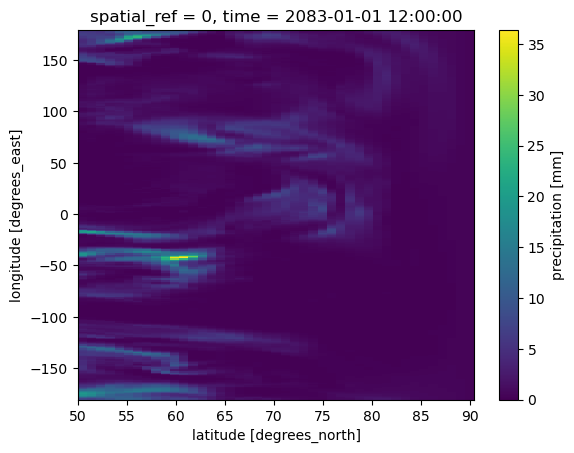

In [20]:
ds["pr"].isel(time=0).plot()  # Plot the first time step of the 'pr' variable

In [21]:
ds.time.attrs  # Check the attributes of the time variable

{}